In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error


In [2]:
# Set file paths
data_path = '../data/'
admissions_file = os.path.join(data_path, 'hosp/admissions.csv.gz')
patients_file = os.path.join(data_path, 'hosp/patients.csv.gz')
transfers_file = os.path.join(data_path, 'hosp/transfers.csv.gz')
labs_file = os.path.join(data_path, 'hosp/labevents.csv.gz')
procedures_file = os.path.join(data_path, 'hosp/procedures_icd.csv.gz')
prescriptions_file = os.path.join(data_path, 'hosp/prescriptions.csv.gz')

In [3]:
# Load datasets
admissions = pd.read_csv(admissions_file, compression='gzip')
patients = pd.read_csv(patients_file, compression='gzip')
transfers = pd.read_csv(transfers_file, compression='gzip')
#labs = pd.read_csv(labs_file, compression='gzip')
procedures = pd.read_csv(procedures_file, compression='gzip')
#prescriptions = pd.read_csv(prescriptions_file, compression='gzip')

In [4]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546028 entries, 0 to 546027
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   subject_id            546028 non-null  int64 
 1   hadm_id               546028 non-null  int64 
 2   admittime             546028 non-null  object
 3   dischtime             546028 non-null  object
 4   deathtime             11790 non-null   object
 5   admission_type        546028 non-null  object
 6   admit_provider_id     546024 non-null  object
 7   admission_location    546027 non-null  object
 8   discharge_location    396210 non-null  object
 9   insurance             536673 non-null  object
 10  language              545253 non-null  object
 11  marital_status        532409 non-null  object
 12  race                  546028 non-null  object
 13  edregtime             379240 non-null  object
 14  edouttime             379240 non-null  object
 15  hospital_expire_f

In [5]:
patients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364627 entries, 0 to 364626
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   subject_id         364627 non-null  int64 
 1   gender             364627 non-null  object
 2   anchor_age         364627 non-null  int64 
 3   anchor_year        364627 non-null  int64 
 4   anchor_year_group  364627 non-null  object
 5   dod                38301 non-null   object
dtypes: int64(3), object(3)
memory usage: 16.7+ MB


In [6]:
# Merge datasets
merged_data = pd.merge(admissions, patients, on='subject_id', how='inner')


In [7]:
merged_data.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'gender',
       'anchor_age', 'anchor_year', 'anchor_year_group', 'dod'],
      dtype='object')

## Preprocessing

In [8]:
admissions.race.value_counts()

race
WHITE                                        336538
BLACK/AFRICAN AMERICAN                        75482
OTHER                                         19788
WHITE - OTHER EUROPEAN                        13972
UNKNOWN                                       13870
HISPANIC/LATINO - PUERTO RICAN                10903
HISPANIC OR LATINO                             8287
ASIAN                                          7809
ASIAN - CHINESE                                7644
WHITE - RUSSIAN                                6597
BLACK/CAPE VERDEAN                             6205
HISPANIC/LATINO - DOMINICAN                    6070
BLACK/CARIBBEAN ISLAND                         3875
BLACK/AFRICAN                                  3495
UNABLE TO OBTAIN                               3478
PATIENT DECLINED TO ANSWER                     2162
PORTUGUESE                                     2082
ASIAN - SOUTH EAST ASIAN                       1973
WHITE - EASTERN EUROPEAN                       1886
HISPANI

In [9]:
category_mapping = {
    # WHITE categories
    'WHITE': 'WHITE',
    'WHITE - OTHER EUROPEAN': 'WHITE',
    'WHITE - RUSSIAN': 'WHITE',
    'WHITE - EASTERN EUROPEAN': 'WHITE',
    'WHITE - BRAZILIAN': 'WHITE',
    
    # BLACK/AFRICAN categories
    'BLACK/AFRICAN AMERICAN': 'BLACK/AFRICAN',
    'BLACK/CAPE VERDEAN': 'BLACK/AFRICAN',
    'BLACK/CARIBBEAN ISLAND': 'BLACK/AFRICAN',
    'BLACK/AFRICAN': 'BLACK/AFRICAN',
    
    # HISPANIC categories
    'HISPANIC OR LATINO': 'HISPANIC',
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC',
    'HISPANIC/LATINO - DOMINICAN': 'HISPANIC',
    'HISPANIC/LATINO - GUATEMALAN': 'HISPANIC',
    'HISPANIC/LATINO - ASIAN INDIAN': 'HISPANIC',
    'HISPANIC/LATINO - SALVADORAN': 'HISPANIC',
    'HISPANIC/LATINO - COLUMBIAN': 'HISPANIC',
    'HISPANIC/LATINO - MEXICAN': 'HISPANIC',
    'HISPANIC/LATINO - HONDURAN': 'HISPANIC',
    'HISPANIC/LATINO - CUBAN': 'HISPANIC',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'HISPANIC',
    
    # ASIAN categories
    'ASIAN': 'ASIAN',
    'ASIAN - CHINESE': 'ASIAN',
    'ASIAN - SOUTH EAST ASIAN': 'ASIAN',
    'ASIAN - ASIAN INDIAN': 'ASIAN',
    'ASIAN - KOREAN': 'ASIAN',
    
    # OTHER categories (updated and explicitly included)
    'AMERICAN INDIAN/ALASKA NATIVE': 'OTHER',
    'SOUTH AMERICAN': 'OTHER',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'OTHER',
    'PORTUGUESE': 'OTHER',
    'MULTIPLE RACE/ETHNICITY': 'OTHER',
    'UNKNOWN': 'OTHER',
    'UNABLE TO OBTAIN': 'OTHER',
    'PATIENT DECLINED TO ANSWER': 'OTHER'
}

In [10]:
admissions['race_grouped'] = admissions['race'].map(category_mapping)

In [11]:
admissions.race_grouped.value_counts()

race_grouped
WHITE            360519
BLACK/AFRICAN     89057
HISPANIC          32210
OTHER             24703
ASIAN             19751
Name: count, dtype: int64

In [12]:
# merged admissoions and patients data sets 
merged_data = pd.merge(admissions, patients, on='subject_id', how='inner')

In [13]:
merged_data.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,race,edregtime,edouttime,hospital_expire_flag,race_grouped,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,...,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0,WHITE,F,52,2180,2014 - 2016,2180-09-09
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,...,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0,WHITE,F,52,2180,2014 - 2016,2180-09-09
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,...,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0,WHITE,F,52,2180,2014 - 2016,2180-09-09
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,...,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0,WHITE,F,52,2180,2014 - 2016,2180-09-09
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,...,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0,WHITE,F,19,2160,2008 - 2010,NaN


In [14]:
# Feature engineering
merged_data['admittime'] = pd.to_datetime(merged_data['admittime'])
merged_data['dischtime'] = pd.to_datetime(merged_data['dischtime'])
merged_data['time_in_hospital'] = (merged_data['dischtime'] - merged_data['admittime']).dt.total_seconds() / 3600
merged_data = merged_data[merged_data['time_in_hospital'] >= 3]  # Exclude admissions less than 3 hours
merged_data['gender'] = merged_data['gender'].map({'M': 0, 'F': 1})
merged_data = pd.get_dummies(merged_data, columns=['race_grouped','gender', 'admission_type','insurance', 'admission_location'], drop_first=True)

In [15]:
merged_data.head()

,subject_id,hadm_id,admittime,dischtime,deathtime,admit_provider_id,discharge_location,language,marital_status,race,...,admission_location_CLINIC REFERRAL,admission_location_EMERGENCY ROOM,admission_location_INFORMATION NOT AVAILABLE,admission_location_INTERNAL TRANSFER TO OR FROM PSYCH,admission_location_PACU,admission_location_PHYSICIAN REFERRAL,admission_location_PROCEDURE SITE,admission_location_TRANSFER FROM HOSPITAL,admission_location_TRANSFER FROM SKILLED NURSING FACILITY,admission_location_WALK-IN/SELF REFERRAL
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,P49AFC,HOME,English,WIDOWED,WHITE,...,False,False,False,False,False,False,False,True,False,False
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,P784FA,HOME,English,WIDOWED,WHITE,...,False,True,False,False,False,False,False,False,False,False
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,P19UTS,HOSPICE,English,WIDOWED,WHITE,...,False,True,False,False,False,False,False,False,False,False
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,P06OTX,HOME,English,WIDOWED,WHITE,...,False,True,False,False,False,False,False,False,False,False
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,P39NWO,NaN,English,SINGLE,WHITE,...,False,True,False,False,False,False,False,False,False,False


In [16]:
merged_data.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admit_provider_id', 'discharge_location', 'language', 'marital_status',
       'race', 'edregtime', 'edouttime', 'hospital_expire_flag', 'anchor_age',
       'anchor_year', 'anchor_year_group', 'dod', 'time_in_hospital',
       'race_grouped_BLACK/AFRICAN', 'race_grouped_HISPANIC',
       'race_grouped_OTHER', 'race_grouped_WHITE', 'gender_1',
       'admission_type_DIRECT EMER.', 'admission_type_DIRECT OBSERVATION',
       'admission_type_ELECTIVE', 'admission_type_EU OBSERVATION',
       'admission_type_EW EMER.', 'admission_type_OBSERVATION ADMIT',
       'admission_type_SURGICAL SAME DAY ADMISSION', 'admission_type_URGENT',
       'insurance_Medicare', 'insurance_No charge', 'insurance_Other',
       'insurance_Private', 'admission_location_CLINIC REFERRAL',
       'admission_location_EMERGENCY ROOM',
       'admission_location_INFORMATION NOT AVAILABLE',
       'admission_location_INTERNAL TRANSFER TO O

In [17]:
merged_data.time_in_hospital.head()

0    18.866667
1    24.366667
2    42.100000
3    53.333333
4     7.166667
Name: time_in_hospital, dtype: float64

In [18]:
merged_data.time_in_hospital.max()

12373.5

In [19]:
merged_data.time_in_hospital.min()

3.0

In [20]:
#Selecting columns for x from merged data
selected_cols = ['anchor_age', 'insurance_Medicare', 'insurance_No charge', 'insurance_Other','gender_1','race_grouped_BLACK/AFRICAN',
       'race_grouped_HISPANIC', 'race_grouped_OTHER', 'race_grouped_WHITE',
       'insurance_Private', 'admission_location_EMERGENCY ROOM',
       'admission_location_INFORMATION NOT AVAILABLE',
       'admission_location_INTERNAL TRANSFER TO OR FROM PSYCH',
       'admission_location_PACU', 'admission_location_PHYSICIAN REFERRAL',
       'admission_location_PROCEDURE SITE',
       'admission_location_TRANSFER FROM HOSPITAL',
       'admission_location_TRANSFER FROM SKILLED NURSING FACILITY',
       'admission_location_WALK-IN/SELF REFERRAL']

In [21]:
# Define features and target
X = merged_data[selected_cols]
y = merged_data['time_in_hospital']

In [22]:
# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


## Linear Regression

In [23]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, lr_pred)))


Linear Regression RMSE: 166.79281728071933


## Random Forest Regression

In [24]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, rf_pred)))


Random Forest RMSE: 169.8440992471212



Top Features by Importance in Random Forest:
                                              Feature  Importance
0                                          anchor_age    0.390587
16          admission_location_TRANSFER FROM HOSPITAL    0.139551
12  admission_location_INTERNAL TRANSFER TO OR FRO...    0.078131
4                                            gender_1    0.075860
1                                  insurance_Medicare    0.047184
5                          race_grouped_BLACK/AFRICAN    0.038537
8                                  race_grouped_WHITE    0.036236
9                                   insurance_Private    0.034867
7                                  race_grouped_OTHER    0.030867
6                               race_grouped_HISPANIC    0.029382


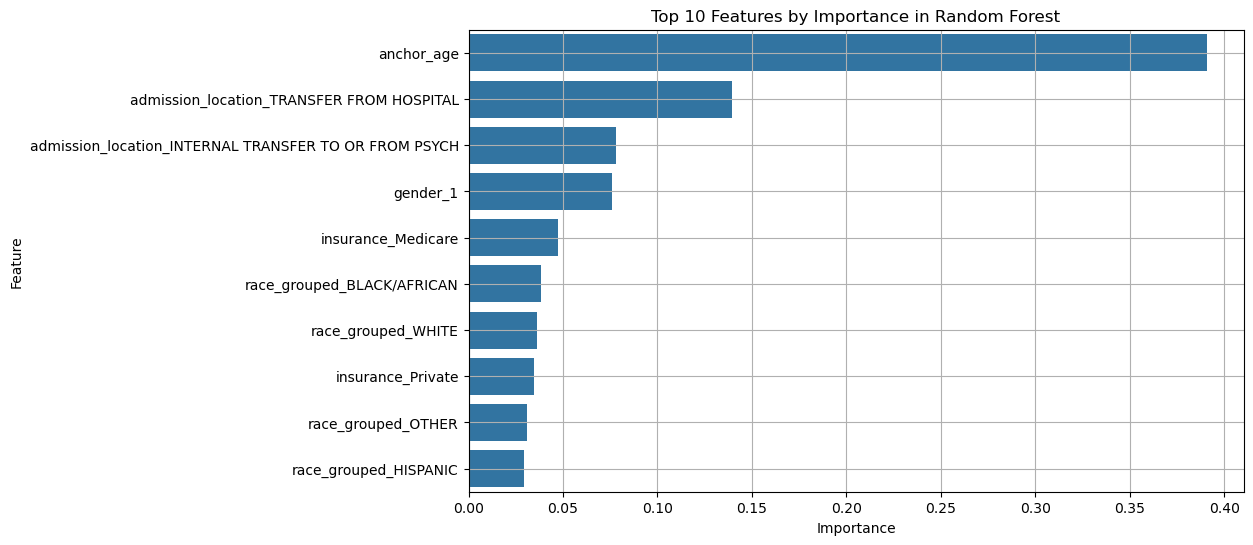

In [25]:
# Feature importances from Random Forest
feature_importances = rf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nTop Features by Importance in Random Forest:")
print(importance_df.head(10))

# Plot Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Features by Importance in Random Forest')
plt.grid()
plt.show()



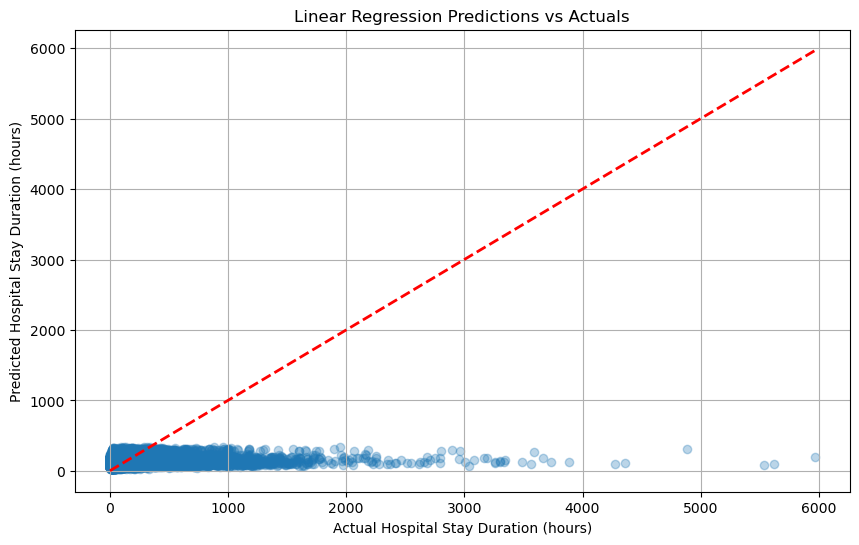

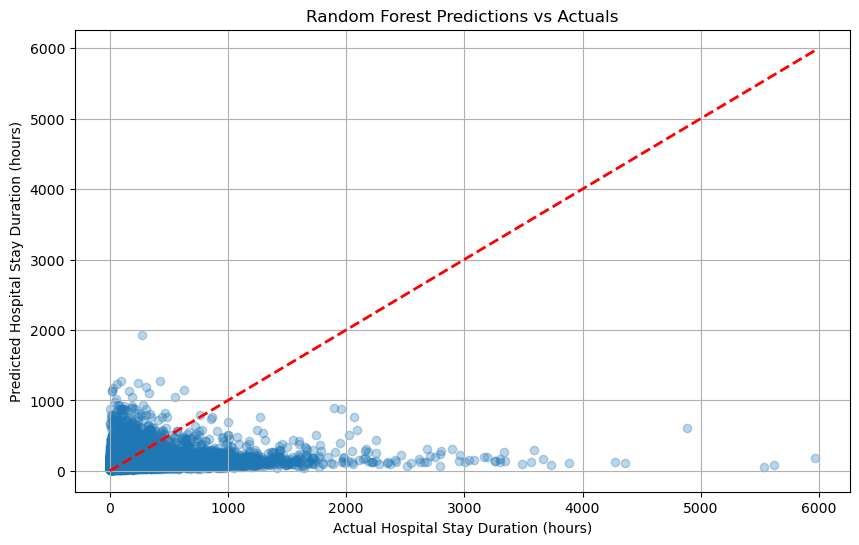

In [26]:
import matplotlib.pyplot as plt

# Compare predictions visually
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.title(f'{model_name} Predictions vs Actuals')
    plt.xlabel('Actual Hospital Stay Duration (hours)')
    plt.ylabel('Predicted Hospital Stay Duration (hours)')
    plt.grid()
    plt.show()

# Plot Linear Regression Predictions
plot_predictions(y_test, lr_pred, "Linear Regression")

# Plot Random Forest Predictions
plot_predictions(y_test, rf_pred, "Random Forest")
    

## LightGBM Classifier

In [47]:
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

# Initialize LGBMRegressor
lgbm = LGBMRegressor(
    objective='regression',
    boosting_type='gbdt',
    n_estimators=1000,  # Set high to allow early stopping
    learning_rate=0.1,
    random_state=42
)

# Fit with early stopping
lgbm.fit(
    X_train,
    y_train,
    eval_set=[(X_val, y_val)],
    eval_metric='rmse',           # Use RMSE as the evaluation metric
    callbacks=[
        lightgbm.early_stopping(stopping_rounds=10),  # Enable early stopping
        lightgbm.log_evaluation(1)                   # Log evaluation metrics
    ]
)

# Predictions
lgbm_pred = lgbm.predict(X_test)

# Evaluate Performance
rmse = np.sqrt(mean_squared_error(y_test, lgbm_pred))
print("LightGBM RMSE:", rmse)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 110
[LightGBM] [Info] Number of data points in the train set: 377556, number of used features: 19
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 115.638668
[1]	valid_0's rmse: 171.35	valid_0's l2: 29360.7
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 170.602	valid_0's l2: 29105.2
[3]	valid_0's rmse: 169.982	valid_0's l2: 28894
[4]	valid_0's rmse: 169.481	valid_0's l2: 28723.9
[5]	valid_0's rmse: 169.062	valid_0's l2: 28581.8
[6]	valid_0's rmse: 168.734	valid_0's l2: 28471.2
[7]	valid_0's rmse: 168.446	valid_0's l2: 28374.1
[8]	valid_0's rmse: 168.

## Neural Network

In [31]:
# Neural Network with PyTorch
class NeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(16, 4)
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.output(x))
        return x

In [34]:
print(X_train.dtypes)

anchor_age                                                   int64
insurance_Medicare                                            bool
insurance_No charge                                           bool
insurance_Other                                               bool
gender_1                                                      bool
race_grouped_BLACK/AFRICAN                                    bool
race_grouped_HISPANIC                                         bool
race_grouped_OTHER                                            bool
race_grouped_WHITE                                            bool
insurance_Private                                             bool
admission_location_EMERGENCY ROOM                             bool
admission_location_INFORMATION NOT AVAILABLE                  bool
admission_location_INTERNAL TRANSFER TO OR FROM PSYCH         bool
admission_location_PACU                                       bool
admission_location_PHYSICIAN REFERRAL                         

In [37]:
X_train = X_train.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

#X_val = X_val.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
#X_test = X_test.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)


In [38]:
print(X_train.dtypes)

anchor_age                                                   int64
insurance_Medicare                                           int64
insurance_No charge                                          int64
insurance_Other                                              int64
gender_1                                                     int64
race_grouped_BLACK/AFRICAN                                   int64
race_grouped_HISPANIC                                        int64
race_grouped_OTHER                                           int64
race_grouped_WHITE                                           int64
insurance_Private                                            int64
admission_location_EMERGENCY ROOM                            int64
admission_location_INFORMATION NOT AVAILABLE                 int64
admission_location_INTERNAL TRANSFER TO OR FROM PSYCH        int64
admission_location_PACU                                      int64
admission_location_PHYSICIAN REFERRAL                        i

In [41]:
print(X_train.dtypes)

anchor_age                                                   int64
insurance_Medicare                                           int64
insurance_No charge                                          int64
insurance_Other                                              int64
gender_1                                                     int64
race_grouped_BLACK/AFRICAN                                   int64
race_grouped_HISPANIC                                        int64
race_grouped_OTHER                                           int64
race_grouped_WHITE                                           int64
insurance_Private                                            int64
admission_location_EMERGENCY ROOM                            int64
admission_location_INFORMATION NOT AVAILABLE                 int64
admission_location_INTERNAL TRANSFER TO OR FROM PSYCH        int64
admission_location_PACU                                      int64
admission_location_PHYSICIAN REFERRAL                        i

In [42]:
X_val = X_val.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)
X_test = X_test.apply(lambda x: x.astype(int) if x.dtype == 'bool' else x)

In [43]:
# Prepare data for PyTorch
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


In [44]:
# Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
model = NeuralNetwork(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [45]:
# Training loop
epochs = 20
batch_size = 32
for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(X_train_tensor.size(0))
    for i in range(0, X_train_tensor.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
    print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss.item():.4f}")

# Testing
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor).numpy().flatten()
print("Neural Network RMSE:", np.sqrt(mean_squared_error(y_test, test_outputs)))


Epoch 1/20, Validation Loss: 42950.8672
Epoch 2/20, Validation Loss: 42950.8672
Epoch 3/20, Validation Loss: 42950.8672
Epoch 4/20, Validation Loss: 42950.8672
Epoch 5/20, Validation Loss: 42950.8672
Epoch 6/20, Validation Loss: 42950.8672
Epoch 7/20, Validation Loss: 42950.8672
Epoch 8/20, Validation Loss: 42950.8672
Epoch 9/20, Validation Loss: 42950.8672
Epoch 10/20, Validation Loss: 42950.8672
Epoch 11/20, Validation Loss: 42950.8672
Epoch 12/20, Validation Loss: 42950.8672
Epoch 13/20, Validation Loss: 42950.8672
Epoch 14/20, Validation Loss: 42950.8672
Epoch 15/20, Validation Loss: 42950.8672
Epoch 16/20, Validation Loss: 42950.8672
Epoch 17/20, Validation Loss: 42950.8672
Epoch 18/20, Validation Loss: 42950.8672
Epoch 19/20, Validation Loss: 42950.8672
Epoch 20/20, Validation Loss: 42950.8672
Neural Network RMSE: 205.9433848161464
